# FDC Estimation

This notebook contains the main code for computing FDCs by the different methods. 

To run this notebook, several pre-requisites must be met.

1. The data must be downloaded and pre-processed (baseline distributions, global mean FDC computed) as described in Notebook 1.
2. The the network partitioning file must be created as described in Notebook 2.
3. The runoff statistics must be computed as described in Notebook 3.

**Sensitivity analysis** follows the main FDC estimation code.  This includes testing the effects of:

* variability on performance measures against the baseline distributions,
* sampling variability on the reference distribution and how it propagates to performance scores when evaluated against FDCs estimated by kNN,
* varying the number of quantiles defining the FDC support,
* random model initialization on the LSTM and log-normal FDC estimates
* sensitivity of kNN performance scores on quantile tail trimming $[\epsilon, 1-\epsilon]$ and uniform noise mixture strength $P = (1 - \lambda) P_ + \lambda \mathbb{U}$


In [6]:
import os
import pandas as pd
import numpy as np
import json
from time import time
import geopandas as gpd

import xgboost as xgb
xgb.config_context(verbosity=2)

from collections import defaultdict
from multiprocessing import Pool, cpu_count

import jax
import jax.numpy as jnp

from utils.kde_estimator import KDEEstimator
from utils.knn_estimator import kNNEstimator
from utils.LSTM_estimator import LSTMFDCEstimator
from utils.parametric_estimator import ParametricFDCEstimator
from utils.fdc_estimator_context import FDCEstimationContext 
from utils.fdc_data import StationData
from utils.evaluation_metrics import EvaluationMetrics

import utils.data_processing_functions as dpf

from pathlib import Path

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from math import comb
# from bokeh.plotting import figure, show, output_file
from bokeh.models import ColorBar, BasicTicker, HoverTool, ColumnDataSource, Whisker
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256

import xyzservices.providers as xyz
tiles = xyz['USGS']['USTopo']
output_notebook()

BASE_DIR = os.getcwd()

Loading BokehJS ...

In [7]:
# load the catchment characteristics
fname = f'catchment_attributes_with_runoff_stats.csv'
attr_df = pd.read_csv(os.path.join('data', fname), dtype={'official_id': str, 'drainage_area_km2': float})
attr_df.columns = [c.lower() for c in attr_df.columns]
attr_df['log_drainage_area_km2'] = np.log(attr_df['drainage_area_km2'])
# attr_df = attr_df[~attr_df['official_id'].isin(exclude)]
# attr_df.columns = [c.lower() for c in attr_df.columns]
attr_df['tmean'] = (attr_df['tmin'] + attr_df['tmax']) / 2.0
station_ids = attr_df['official_id'].values
stn_da_dict = attr_df.set_index('official_id')['drainage_area_km2'].to_dict()
# assert '12414900' in station_ids

print(f'There are {len(station_ids)} monitored basins in the attribute set.')

There are 1017 monitored basins in the attribute set.


In [8]:
# load the pre-computed dictionary of complete years of record for each station
with open(os.path.join('data', 'complete_years.json'), 'r') as f:
    complete_years_dict = json.load(f)

In [9]:
# streamflow folder from (updated) HYSETS
HYSETS_DIR = Path('/home/danbot/code/common_data/HYSETS')
# STREAMFLOW_DIR = HYSETS_DIR / 'streamflow'

hs_df = pd.read_csv('data/HYSETS_watershed_properties.txt', sep=';', dtype={'Official_ID': str})
hs_df = hs_df[hs_df['Official_ID'].isin(station_ids)]
hs_df.head(2)

,Watershed_ID,Source,Name,Official_ID,Centroid_Lat_deg_N,Centroid_Lon_deg_E,Drainage_Area_km2,Drainage_Area_GSIM_km2,Flag_GSIM_boundaries,Flag_Artificial_Boundaries,...,Land_Use_Wetland_frac,Land_Use_Water_frac,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Flag_Land_Use_Extraction,Permeability_logk_m2,Porosity_frac,Flag_Subsoil_Extraction
846,847,HYDAT,CROWSNEST RIVER AT FRANK,05AA008,49.59732,-114.4106,402.6522,NaN,0,0,...,0.0103,0.0065,0.0328,0.0785,0.0015,0.0002,1,-15.543306,0.170479,1
849,850,HYDAT,CASTLE RIVER NEAR BEAVER MINES,05AA022,49.48866,-114.1444,820.6510,NaN,0,0,...,0.0058,0.0023,0.0105,0.1156,0.0246,0.0000,1,-15.929747,0.150196,1


In [10]:
# load the baseline PMFs from the previous notebook
# pmf_path = Path(os.getcwd()) / 'data' / 'results' / 'baseline_distributions' / f'pmf_kde.csv'
# pmf_df = pd.read_csv(pmf_path, index_col=0)
# pmf_stations = pmf_df.columns
# station_ids = list(set(station_ids).intersection(set(pmf_stations)))
# print(len(station_ids))

In [11]:
# Exclude catchments found to be regulated (missed by QC)
# 12143700 isnot actually a dam, it's just basically a seepage monitoring station
# from a small catchment next to a dam 
exclude_stations = ['08FA009', '08GA037', '08NC003', '12052500', '12090480', '12107950', '12108450', '12119300', 
                    '12119450', '12200684', '12200762', '12203000', '12409500', '15056070', '15081510',
                    '12323760', '12143700', '12143900', '12398000', '12058800', '12137800', '12100000']


In [12]:
# retrieve LSTM ensemble predictions
LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250514' # based on mean NSE loss
# LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250627' # based on 95% NSE loss
lstm_result_files = os.listdir(LSTM_ensemble_result_folder)
lstm_result_stns = [e.split('_')[0] for e in lstm_result_files]
assert '12414900' in lstm_result_stns

# find any non-matching station ids in the lstm result files
stns_to_remove_from_lstm_set = []
for stn in lstm_result_stns:
    if stn not in station_ids:
        # try adding a leading zero
        ending_in = [e for e in station_ids if e.endswith(stn)]
        if len(ending_in) > 0:
            print(stn, 'matches', ending_in)
        modified_stn = stn.zfill(8)
        if modified_stn in station_ids:
            print(f'Found modified station id: {modified_stn} for {stn}')
        else:
            print(f'Warning: {stn} is in LSTM results but not in the station attributes.')
            stns_to_remove_from_lstm_set.append(stn)

# filter for the common stations between BCUB region and LSTM-compatible (i.e. 1980-)
daymet_concurrent_stations = list(set(station_ids) & set(lstm_result_stns))# & set(official_ids_to_include))
# assert '12414900' in daymet_concurrent_stations
# print(f'There are {len(pmf_stations)} monitored basins with baseline PMFs.')
print(f'There are {len(daymet_concurrent_stations)} monitored basins concurrent with LSTM ensemble results.')

There are 715 monitored basins concurrent with LSTM ensemble results.


In [13]:
# simple check to make sure "DAM" is not in the station name 
#  -- commonly used to indicate regulated stations
for stn in daymet_concurrent_stations:
    hs_data = hs_df[hs_df['Official_ID'] == stn].copy()
    name = hs_data['Name']
    if 'DAM' in name:
        print(stn, name)
    if 'RESERVOIR' in name:
        print(stn, name)


## Non-Parametric Simulation

### Time-based ensemble

A probability distribution $\hat p = f(\tilde x(t))$ is estimated for a target (ungauged location) by a weighted mean of runoff time-series from k nearest neighbour stations, $\tilde x(t) = \textbf{X}(t)\cdot w$ where $X(t) \in \mathbb{R}^{N \times k}$ and $w \in \mathbb{R}^{k\times 1}$ is a vector of k weights.  So $\hat p = f(\textbf{X}(t) \cdot w )$  Weights $w$ are computed in three ways, described in the next subsection, and k-nearest neighbours are selected using the criteria defined below.  Each gauged station in the monitoring network is treated as an ungauged location to generate a large sample of simulations across hydrologically diverse catchments, or rather as many catchments as can be tested.

### Frequency-based ensembles

A simulated probability density function is estimated from observations of k nearest neighbour stations.  First, k simulated series are generated by equal unit area runoff , $\hat p = \hat P \cdot w$ where $\hat P = [\hat p_1, \hat p_2, \cdots, \hat p_k]$ and each $\hat p_i = f(X_i(t))$.

In both cases, the function $f \rightarrow \hat p(x)$ represents kernel density estimation, which defines the probability density as $$\hat p(x) = \frac{1}{n \cdot h(x)} \sum_{i=1}^{n}K\left( \frac{x-x_i}{h(x)}\right)$$ 

Where $h(x)$ reflects an adaptive kernel bandwidth that addresses vestiges of precision in the observed data to reflect the nature of streamflow as a continuous variable, and additionally incorporates piecewise linear model to represent overall measurement uncertainty.


## Notes on k-nearest neighbours

Time series streamflow records vary widely in their temporal coverage, and finding k-nearest neighbours presents a tradeoff between selecting nearest neighbours and maximizing the number of observations concurrent with the target.  From the literature, concurrency is assured by pre-selecting a subset of stations with continuous records over a common period of record, or by infilling gaps with k-nearest neighbours simulation.  Some kind of tradeoff must be made, and we aim to use a method that maximizes information content while minimizing the number of assumptions.  The following notes are intended to clarify the implications of using k-nearest neighbours to fill gaps in the time series.

1. **Infilled-by-kNN != Independent Proxy**: If a gap in an observation record is inferred from neighbors, its inclusion in the ensemble is functionally equivalent to increasing the ensemble size.

2. **Information leakage risk**: Excessive infilling of missing data, risks suppressing variability by biasing toward the central tendency of the ensemble.  This defeats one of the motivations for using kNN: to preserve structure and variability from observations at neighboring stations.

To address the nuance above, three time-based methods are defined for selecting k-nearest neighbours beyond the strict interpretation of nodes in the network.  The problem is related to the set-cover problem where the goal is to select a subset of stations that maximizes the intersection of their data availability over a specified time period.  The following sections outline the three methods for selecting k-nearest neighbours based on availability of concurrent data.

|                                        | Description |
|----------------------------------------|-------------|
| Set Intersection Selection             | Select \( k \) nodes whose intersection satisfies a completeness constraint. |
| Maximum Coverage under Cardinality Constraint | Choose \( k \) nodes to maximize the coverage (or completeness) of their intersection. |
| Recursive k-Subset Validation          | If the initial \( k \) nodes fail, iteratively add more candidates and evaluate all \( \binom{k+1}{k} \) combinations, and so on. |
| NP-Hard Nature                         | This problem is computationally hard and shares structure with the Set Cover and Maximum Coverage problems. |


### Summary: Set-Theoretic implications of strict k-NN concurrency selection

This problem is closely related to classic combinatorial and set-theoretic optimization problems.

#### Set-Theoretic Definition

Let each column $( S_i \subseteq T )$ represent the set of timestamps where station $( i )$ has valid (non-NaN) data.  
Let $( \mathcal{S} = \{ S_1, S_2, \dots, S_n \} )$ be the collection of all such subsets, sorted by proximity (e.g., distance or attribute similarity).  
The goal is to select a subset $( \mathcal{K} \subset \mathcal{S} )$ such that:
- $( |\mathcal{K}| = k )$
- $( \bigcap_{S \in \mathcal{K}} S )$ satisfies a temporal completeness constraint (e.g., ≥5 years with ≥10 observations in each of 12 months)

This is a constrained subset selection problem on the intersection of sets.

#### Practical Implication

This formulation justifies using greedy or approximate subset selection strategies when exhaustively testing all combinations becomes computationally infeasible.





## Define a universal parametric prior

In order to fairly test how parametric and non-parametric pdf estimation methods compare to each other, we need a consistent way to deal with indeterminate cases where the simulated distribution does not provide support coverage of the "ground truth" observations.  I feel two ways about this: the KL divergence is the culprit here, and the problem could be avoided by choosing another divergence measure.  However the definintion of KL divergence in information theoretic terms of compression and optimal encoding seem more foundational than other measures that reflect utility in some way. Should we look to math statistics to make more direct links between f-divergences and what we use as a discriminant for a particular application?  Should we be more concerned about "Bayesian consistency" of the discriminant (or surrogate loss function) with the choice of divergence measure?


1.  **Quantify the distribution of unsupported mass across all models**.  It is important to describe the extent of the problem across the sample **and** across various methods.  i.e. discrete distributions have the issue of support coverage, but so do all methods!
2.  Even in kNN / ensemble simulation approaches, the problem of incomplete support coverage necessitates specifying some form of prior in the likelihood function.  The issue is that setting a uniform prior over the observed range takes advantage of information about the observed range.  We got around this by setting a global support assumption and discretizing the range into bins according to an assumption about measurement precision.  i.e. given the global range, we used $2^{10}$ bins spaced evenly on a log scale to reflect roughly 1% relative precision.  

### Global support quantization

$$f(x) = \frac{1}{b-a}, \quad x\in (a, b) \text{ and } f(x) = 0 \text{ otherwise.}$$
$$\int_a^b f(x)\text{dx} = 1$$

Given the target range is a sub interval $(c, d) \subseteq (a, b)$, then the **total** probability mass over (c, d) is:

$$M_\text{target} = \int_c^d \frac{1}{b-a}\text{dx} = \frac{d-c}{b-a}$$

Over the set of intervals $\Delta x_i$ covering the **target range**, the probability mass associated with each interval (bin) is given by: 

$$\Delta x_i \frac{d-c}{b-a}$$



### Compute the mean PDF across all stations

Given a state space $\Omega$ with $M$ discrete states, and $N$ spatially distributed sensors (streamflow monitoring stations) with PMFs $P=\{p_j\}_{j=1}^N$, we can define the mean PDF across all sensors in terms of the observed states $\omega$ as follows:

$$\Omega=\{\omega_i\}_{i=1}^M,\quad P\in\mathbb{R}^{M\times N},\quad P_{i j}=p_j(\omega_i),\ \sum_{i=1}^M P_{i j}=1.$$

$$P_{i j}=\Pr_j(B_i),\qquad \bar p_i =\frac{1}{N}\sum_{j=1}^N P_{i j}\quad(\text{mean PMF over sensors}).$$

where $B_i$ denotes the $i$-th quantization bin (interval) in log-unit-area-runoff (L-UAR), i.e., $B_i = [y_i, y_{i+1})$ with $y_i = \log(x_i)$. Each $P_{ij}$ is the probability assigned by sensor $j$ to bin $B_i$.

$$\text{Density per log-}x\ (\text{piecewise constant on }B_i):\quad h_i=\frac{\bar p_i}{\Delta y_i},\qquad \sum_i h_i\,\Delta y_i=1$$




### Entropy of the mean PDF and fraction of $b$-bit quantization capacity

$$M = 2^{b},\qquad \bar{\mathbf p} = (\bar p_1,\ldots,\bar p_M)^T,\quad \bar p_i \ge 0,\ \sum_{i=1}^M \bar p_i = 1$$

$$\text{Shannon entropy (bits):}\quad H_2(\bar{\mathbf p}) \;=\; -\sum_{i:\,\bar p_i>0} \bar p_i \log_2 \bar p_i \;\le\; b.
$$

$$\text{Normalized entropy (fraction of capacity):}\quad \rho_b \;=\; \frac{H_2(\bar{\mathbf p})}{b} \in [0,1].$$

$$\text{Perplexity (effective bins):}\quad \mathcal P(\bar{\mathbf p}) \;=\; 2^{H_2(\bar{\mathbf p})},\qquad
\text{occupancy fraction } \phi_b \;=\; \frac{\mathcal P}{2^b} \;=\; 2^{H_2(\bar{\mathbf p})-b}.
$$

## Notes on FDC estimation from distribution mixtures

A desirable property of the estimated FDC is that it prevents predicting zero probabilities over the support $\Omega$ while reflecting the strength of belief in the model (data).  To avoid predicting zero probabilities over the support, a component of the FDC estimation model is to add a uniform distribution component in the form of a mixture model: $\hat Q = (1 - \lambda) Q + \lambda \mathbb{U}$, where $U$ is the uniform distribution over the support.  The mixture ratio $\lambda$ reflects the strength of belief in the model (data), where a smaller $\lambda$ reflects stronger belief in the data/model and vice versa.  The strength of belief in the uniform component is a way of controlling how the addition of information by uniform noise influences the estimated distribution.  More importantly, the "surprise" of observing a state $p_i > 0$ where $q_i \rightarrow 0$ grows to infinity, so care must be taken not just to prevent infinite divergence but also to consider what the addition of uniform noise in its place represents as far as a certainty in the frequency itself.  Simply assigning a very small number is not appropriate since it has a clear interpretation in terms of an expectation of how long it would take on average to observe the state. The mixture with a uniform component should not be so small as to represent a) a high degree of certainty in an event and b) an event that is far more rare than the observed duration without supporting (prior) information.


1.  Incomplete support coverage, or underspecification, is infinitely penalized when the ground truth probability is nonzero..  The method does not tolerate a model that cannot predict the full observed range.
2.  A **proper** probability distribution sums (discrete) or integrates (continuous) to 1.  Very small probabilities are in a sense associated with a high degree of certainty since they reflect the expectation of the system being observed in a particular state.
3.  The penalty of underestimating a state frequency is that storing and transmitting information about the state requires (the log ratio) more bandwidth/disk space because it is assigned a longer bit string than the actual frequency calls for under optimal encoding.
4.  Assigning a very small probability to a state ...

In [14]:
# load the predicted parameter results
parameter_prediction_results_folder = os.path.join('data', 'results', 'parameter_prediction_results', )
predicted_params_fpath   = os.path.join(parameter_prediction_results_folder, 'OOS_parameter_predictions.csv')
rdf = pd.read_csv(predicted_params_fpath, index_col=['official_id'], dtype={'official_id': str})
predicted_param_dict = rdf.to_dict(orient='index')

In [15]:
plots = []
predicted_param_sample = {}
for l, al in zip(['log_uar_mean_predicted', 'log_uar_std_predicted'], [r'$$\text{Log Mean UAR }(L/s/\text{km}^2)$$', r'$$\text{Log SD UAR }(L/s/\text{km}^2)$$']):
    vals = [d[l] for _, d in predicted_param_dict.items()]
    predicted_param_sample[l] = vals
    # plot the histogram of the mean_uar values
    hist, edges = np.histogram(vals, bins=40, density=True)
    # create a scatter plot of the predicted parameter vs the target parameter
    f = figure(title=f'Predicted {l}', width=600, height=400)
    f.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='lightblue', line_color='black', legend_label='')
    f.xaxis.axis_label = al
    f.yaxis.axis_label = r'$$P(x)$$'
    f = dpf.format_fig_fonts(f, font_size=14)
    plots.append(f)
# retrieve all the mean_uar values 

lt = gridplot(plots, ncols=2, width=400, height=400)
show(lt)

In [16]:
class FDCEstimatorRunner:
    def __init__(self, stn_id, ctx, methods, k_nearest, parametric_target_cols, estimator_classes, **kwargs):
        self.stn_id = stn_id
        self.ctx = ctx
        self.methods = methods
        self.k_nearest = k_nearest
        self.parametric_target_cols = parametric_target_cols
        self.ESTIMATOR_CLASSES = estimator_classes
        self._create_results_folders()
        self._create_readme()
        

    def _create_results_folders(self):
        # create a results foder for each method if it doesn't exist
        self.results_folder = os.path.join('data', 'results', f'fdc_estimation_results',)
        for method in self.methods:
            method_folder = os.path.join(self.results_folder, method)
            if method == 'lstm':
                self.lstm_rev_date = self.ctx.LSTM_ensemble_result_folder.split('_')[-1]
                method_folder = os.path.join(self.results_folder, f'{method}_{self.lstm_rev_date}')
            if not os.path.exists(method_folder):
                os.makedirs(method_folder)


    def _create_readme(self):
        # create a readme file in the results folder to list constraints
        readme_file = os.path.join(self.results_folder, 'README.txt')
        
        with open(readme_file, 'w') as file:
            file.write("This folder contains the results of the FDC estimation.\n")
            file.write(f"Methods evaluated: {', '.join(self.methods)}\n")
            # add the concurrency constraint and number of stations represented in the network
            N = len(self.ctx.official_ids)
            if self.ctx.include_pre_1980_data == False:
                file.write(f'Uses only stations within Daymet input period of record / LSTM results: N={N} stations in the network.\n')
                file.write(f'Global start date on streamflow data: {self.ctx.global_start_date}\n')
            else:
                file.write(f'Uses all available network stations in the BCUB region (1950-2024): N={N} stationsin the network.')
                

    def _load_reference_distributions(self):
        self.log_edges = self.data.log_edges
        self.log_w = self.data.log_w
        self.log_x = self.data.log_x
        self.lin_x = self.data.lin_x
        # self.kde = KDEEstimator(self.log_edges)


    def _save_result(self, result):
        with open(self.result_file, 'w') as file:
            json.dump(result, file, indent=4)

 
    def run_selected(self):
        # check the minimum number of years of overlap for all stations in self.ctx.overlap_dict
        for method in self.methods:
            self.result_file = os.path.join(self.results_folder, method, f'{self.stn_id}_fdc_results.json')
            if method == 'lstm':
                method_folder = f'{method}_{self.lstm_rev_date}'
                self.result_file = os.path.join(self.results_folder, method_folder, f'{self.stn_id}_fdc_results.json')
            
            if os.path.exists(self.result_file):
                continue
            else:
                self.data = StationData(self.ctx, self.stn_id)
                self.data.k_nearest = self.k_nearest
                self.data.parametric_target_cols = self.parametric_target_cols
                self._load_reference_distributions()

                # self.data.kde_estimator = self.kde
                self.data.eval_metrics = EvaluationMetrics(data=self.data)

                EstimatorClass = self.ESTIMATOR_CLASSES[method]

                estimator = EstimatorClass(
                    self.ctx, self.data
                )
                result = estimator.run_estimators()
                self._save_result(result)
            # except Exception as e:
            #     raise Exception(f"  {method} estimator failed for {self.stn_id}: {str(e)}")
                

In [17]:
np.random.seed(42)

target_cols = [
    'mean_uar', 'sd_uar', 
    'mean_logx', 'sd_logx', 
]

# set paths for catchment attributes and meteorological forcing data
attr_df_fpath = os.path.join('data', f'catchment_attributes_with_runoff_stats.csv')
LSTM_forcings_folder = '/home/danbot/neuralhydrology/data/BCUB_catchment_mean_met_forcings_20250320'
baseline_distribution_folder = os.path.join('data', 'results', 'baseline_distributions')
# parameter_prediction_results_folder = os.path.join('data', 'parameter_prediction_results')

# set which (subset of) methods to run
methods = ('parametric', 'lstm', 'knn',)
# methods = ('knn',)
k_nearest = 10
include_pre_1980_data = True  # use only stations with data 1980-present concurrent with Daymet
daymet_start_date = '1980-01-01'  # default start date for Daymet data
if include_pre_1980_data:
    daymet_start_date = '1950-01-01'

processed = []
ESTIMATOR_CLASSES = {
    'parametric': ParametricFDCEstimator,
    'lstm': LSTMFDCEstimator,
    'knn': kNNEstimator,
}

In [18]:
input_data = {
    'attr_df_fpath': attr_df_fpath,
    'LSTM_forcings_folder': LSTM_forcings_folder,
    'LSTM_ensemble_result_folder': LSTM_ensemble_result_folder,
    'include_pre_1980_data': include_pre_1980_data,  # use only stations with data 1980-present concurrent with Daymet
    'predicted_param_dict': predicted_param_dict,
    'divergence_measures': ['DKL', 'EMD'],
    'eps': 1e-12,
    'min_flow': 1e-4, # minimum flow value to avoid log(0)
    'n_grid_points': 2**10, # size of the grid for evaluating PMFs
    'min_record_length': 5, # minimum record length (years)
    'minimum_days_per_month': 20, # minimum number of days with valid data per month
    'parametric_target_cols': target_cols,
    'all_station_ids': daymet_concurrent_stations,
    'baseline_distribution_folder': baseline_distribution_folder,
    'delta': 0.01 # maximum perturbation of the predicted PMF by the uniform mixture ratio
}

context = FDCEstimationContext(**input_data)

    Using all stations in the catchment data with a baseline PMF (validated): 715
    ...overlap dict loaded from data/record_overlap_dict.json


In [19]:
processed = []
t0 = time()
process_fdcs = True
if process_fdcs:
    print('Processing FDCs...')
    for stn in daymet_concurrent_stations:
        runner = FDCEstimatorRunner(stn, context, methods, k_nearest, target_cols, ESTIMATOR_CLASSES)
        runner.run_selected()
        processed.append(stn)
        if len(processed) % 25 == 0:
            t1 = time()
            elapsed = t1 - t0
            unit_time = elapsed / len(processed)
            print(f'Processed {len(processed)}/{len(daymet_concurrent_stations)} stations in {unit_time:.2f} seconds per station')

Processing FDCs...
Processed 25/715 stations in 0.00 seconds per station
Processed 50/715 stations in 0.00 seconds per station
Processed 75/715 stations in 0.00 seconds per station
Processed 100/715 stations in 0.00 seconds per station
Processed 125/715 stations in 0.00 seconds per station
Processed 150/715 stations in 0.00 seconds per station
Processed 175/715 stations in 0.00 seconds per station
Processed 200/715 stations in 0.00 seconds per station
Processed 225/715 stations in 0.00 seconds per station
Processed 250/715 stations in 0.00 seconds per station
Processed 275/715 stations in 0.00 seconds per station
Processed 300/715 stations in 0.00 seconds per station
Processed 325/715 stations in 0.00 seconds per station
Processed 350/715 stations in 0.00 seconds per station
Processed 375/715 stations in 0.00 seconds per station
Processed 400/715 stations in 0.00 seconds per station
Processed 425/715 stations in 0.00 seconds per station
Processed 450/715 stations in 0.00 seconds per st

### Compute the complexity of searching the space of k-nearest neighbours for the optimal ensemble


In [ ]:
def plot_search_space_heatmap(N_min=10, N_max=1000, N_step=10, k_max=10):# output_path="search_space_heatmap.html"):
    """
    Generate and save a Bokeh heatmap of log10(search space size) for ensembles of size 1 to k_max
    from a network of size N, excluding the target node.

    Parameters:
    - N_min (int): Minimum network size.
    - N_max (int): Maximum network size.
    - N_step (int): Step between network sizes.
    - k_max (int): Maximum ensemble size to consider.
    - output_path (str): Path to save the HTML output.
    """
    N_values = np.arange(N_min, N_max + 1, N_step)
    k_values = np.arange(1, k_max + 1)

    data = []
    for N in N_values:
        for k in k_values:
            max_j = min(k, N - 1)
            size = sum(comb(N - 1, j) for j in range(1, max_j + 1))
            data.append((N, k, size))

    df = pd.DataFrame(data, columns=['N', 'k', 'search_space'])
    df['log_search_space'] = np.log10(df['search_space'].astype(float).replace(0, np.nan))

    source = ColumnDataSource(df)

    mapper = linear_cmap(field_name='log_search_space', palette=Viridis256,
                         low=df['log_search_space'].min(), high=df['log_search_space'].max())

    hover = HoverTool(
        tooltips=[
            ("N", "@N"),
            ("k", "@k"),
            ("Search space", "@search_space{0,0}"),
            ("log10(Search space)", "@log_search_space{0.00}")
        ]
    )

    p = figure(title="Log10 of Search Space Size vs N and k",
               x_axis_label='Network size N',
               y_axis_label='Ensemble size k',
               x_range=(N_min, N_max), y_range=(1, k_max),
               width=900, height=550,
               tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', hover])

    p.rect(x="N", y="k", width=N_step, height=1, source=source,
           line_color=None, fill_color=mapper)

    color_bar = ColorBar(color_mapper=mapper['transform'], ticker=BasicTicker(),
                         label_standoff=12, location=(0, 0), title='log10(search space)')
    p.add_layout(color_bar, 'right')
    return p

fig = plot_search_space_heatmap()
show(fig)

## Check sensitivity of variance estimation to the selection of quantiles

The Nash-Sutcliffe Efficiency is the RMSE ($\frac{1}{N}\sum(y-\hat y)^2)$) normalized by the observed variance $\sigma^2 = \sum(y-\mu_y)^2$. When the NSE is computed on timeseries observations, the variance at least represents the sample.  When the NSE is used to describe the accuracy of an FDC described on a subjective set of quantiles, i.e. $\{1, 2, \dots, 99\}$, the mean is an approximation that assumes the data are normally distributed.  This is not often the case, so here we examine the sensitivity of this metric to the choice of percentiles.  

In short, the NSE ($1 - \frac{RMSE}{\sigma^2}$), which is already sensitive to outliers, will be overestimated if $\sigma^2$ is overestimated, and vice versa.

### Evaluate how biased a quantile-based spread estimate is at different resolutions

Generate a dummy set of percentiles based on a wide range of number of points used to represent the FDC, and vary the inclusion of extremes.  In other words, vary the start end end points of the percentiles used to represent the FDC.  Including 0 and 100 in the set introduces the most structural uncertainty, and as we (symmetrically) exclude probability from the ends of the distribution, our estimate becomes less susceptible to extreme outlier errors based on the quadratic loss.  Likewise, having too many points (high number of quantiles near 0 and 100) has the same problem if some of the "edge probability" is not trimmed.  

### Conventional Representation of FDCs

In the literature, FDC estimation accuracy is computed in several different ways. One important difference among previous studies is the set of quantiles $\{ p_j \}$ over which residuals of the estimated and observed exceedance duration are evaluated.  The residuals are denoted $e_j = \hat q(p_j) - q(p_j)$, where $\hat q(p_j) = F^{-1}(p_j)$ are the estimated quantiles at exceedance percentiles $p_j$ and $q(p_j)$ are the observed quantiles.  The choice of probabilities reflects different research objectives in representing flow availability.

* [0, 1, ..., 99, 100] {cite}`booker2014comparing`
* [10, 20, ..., 80, 90] {cite}`li2010new`
* [50, 51, ..., 99] {cite}`fennessey1990regional`

The choice of exceedance durations to evaluate FDC estimates is determined on the basis of the precision and range of representation being appropriate for some application or question.  However the interpretation of the performance metric also depends upon this choice, in particular the statistical structure of the values being estimated.  A common metric between studies is the Nash Sutcliffe Efficiency (NSE) which divides the RMSE by the standard deviation.  Normalizing by the standard deviation implicitly assumes the residuals are normally distributed.  Alternatively, by the sample size (N) represents simply the mean, treating all residuals equally regardless of their distribution, except if the residuals are squared, then it emphasizes large values.  {cite}`booker2012comparing` and {cite}`booker2014comparing` (and others...) standardize the observed variable (unit area runoff) by dividing by the mean. 

In [23]:
def percentile_spread_convergence(obs, percentiles_list=None):
    """
    Compare the standard deviation of observed data to that estimated from percentiles.

    Parameters:
    - obs: 1D array-like of observed values
    - percentiles_list: list of lists/arrays of percentiles to compute (0–100).
      If None, defaults to increasingly fine resolutions.

    Returns:
    - pd.DataFrame with columns:
        'num_percentiles', 'percentiles', 'spread_std', 'sample_std', 'relative_error'
    """
    obs = np.asarray(obs)
    sample_std = np.std(obs, ddof=0)
    sample_mean = np.mean(obs)

    if percentiles_list is None:
        percentiles_list = [np.arange(10, 100, 10),
                            np.arange(5, 100, 5),
                            np.arange(2, 100, 2),
                            np.arange(1, 100, 1),
                           np.arange(0.1, 99.9, 0.1),
                           np.arange(0.01, 99.99, 0.01), 
                           np.linspace(0, 100, 1000)]

    results = []
    for pct_set in percentiles_list:
        q_vals = np.percentile(obs, pct_set)
        spread_std = np.std(q_vals)
        spread_mean = np.mean(q_vals)
        rel_error = (spread_std - sample_std) / sample_std
        mean_rel_error = (spread_mean - sample_mean) / sample_mean
        results.append({
            'num_percentiles': len(pct_set),
            'percentiles': pct_set,
            'spread_std': spread_std,
            'sample_std': sample_std,
            'relative_error': rel_error,
            'mean_relative_error': mean_rel_error
        })

    return pd.DataFrame(results)

Note that this test represents a single site.  We are testing the "precision of fdc representation" and the "sensitivity to extremes".  

In [24]:
target_id = '08MH147'
target_da= stn_da_dict[target_id]
test_data = StationData(context, target_id)

# get the unique UAR values
df =  test_data.stn_df.copy()
vals = df[f'{target_id}_uar'].dropna().values
sdf = percentile_spread_convergence(vals)
years = list(set(df.index.year))

In [25]:
def compute_positions(n: int, method: str = "weibull") -> np.ndarray:
    """Return p_k for k=1..n under a given plotting-position method."""
    k = np.arange(1, n + 1, dtype=float)
    if method == "weibull":
        p = k / (n + 1.0)
    elif method == "hazen":
        p = (k - 0.5) / n
    elif method == "gringorten":
        p = (k - 0.44) / (n + 0.12)
    else:
        raise ValueError("Unknown method: %r" % method)
    # ensure open interval (0,1)
    eps = 1e-12
    return np.clip(p, eps, 1 - eps)


def compute_entropy(pmf):
    """Compute the entropy of a discrete probability mass function."""
    pmf = np.asarray(pmf)
    pmf = pmf[pmf > 0]  # Exclude zero probabilities to avoid log(0)
    return np.sum(pmf * np.log2(1/pmf))


def compute_empirical_cdf(data):
    """Compute the empirical CDF of the data."""
    sorted_data = np.sort(data)
    n = len(data)
    ecdf = np.arange(1, n + 1) / n
    return sorted_data, ecdf

In [26]:
a = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.9, 1.3])
b = [1 / len(a)] * len(a)
h = compute_entropy(b)
print(f'Entropy of uniform distribution: {h:.4f} bits')

Entropy of uniform distribution: 3.0000 bits


Compute the effect of sampling variability on the entropy of the estimated distribution.  This is done by bootstrapping the observed data and re-computing the entropy of the estimated distribution.  This is done for a range of quantile set sizes to evaluate how the choice of quantiles affects the sensitivity of the entropy estimate.  Choosing the number of quantiles represents a bias-variance tradeoff as fewer bins smooth out variance from the data.

In [29]:
M_set = [6, 7, 8, 9, 10, 11]  # log2 of number of grid points
# eps_set = [1e-4, 1e-3, 1e-2, 1e-1]  # edge trimming parameter for [eps, 1-eps]
results = []
h_results_fpath = os.path.join('data', 'results', 'entropy_estimates_bootstrapped.csv')
if os.path.exists(h_results_fpath):
    h_df = pd.read_csv(h_results_fpath, index_col=0, dtype={'station_id': str})
else:
    for stn in daymet_concurrent_stations:

        test_data = StationData(context, stn)
        log_edges = test_data.log_edges
        log_x = test_data.log_x

        max_H = np.log2(len(log_x))  # entropy of uniform distribution over the grid
        assert max_H == 10

        S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
        # print(f"Station {stn}: n={S.size} unique={len(np.unique(S))} min={S.min():.4g} max={S.max():.4g}")
        
        # initialize a matrix to hold B boostrap samples of len(S) each
        B = 1000
        rng = np.random.default_rng(42)
        idx = np.random.choice(S.size, size=(S.size, B), replace=True)    
        S_b  = S[idx] # (n, B) bootstrap samples (column vectors of resampled data)

        # for each sample, compute a histogram over log_edges
        histograms = np.apply_along_axis(lambda x: np.histogram(x, bins=log_edges, density=True)[0], arr=S_b, axis=0)
        # convert pdfs to pmfs
        histograms *= test_data.log_w[:, None]  # (M, B) multiply by the bin width
        H = np.apply_along_axis(compute_entropy, arr=histograms, axis=0) # B entropy values

        # format and save results
        results.append((stn, np.mean(H), *np.percentile(H, (2.5, 50, 95))))
        h_df = pd.DataFrame(results, columns=['official_id', 'mean_entropy', 'p2.5', 'p50', 'p97.5'])
        h_df = h_df.set_index('official_id').round(5)
        # save the output to a csv file
        h_df.to_csv(h_results_fpath)



In [30]:
# for each station, compute the 95% confidence interval as a percentage of the median
h_df['dh_95'] = h_df['p97.5'] - h_df['p2.5']
p = figure(title='', width=600, height=400, toolbar_location=None)
p.scatter(h_df['mean_entropy'], 100 * h_df['dh_95'] / h_df['mean_entropy'], size=3, color='black', alpha=0.5)
p.xaxis.axis_label = 'Mean Entropy H [bits]'
p.yaxis.axis_label = '95% CI as % of Mean H [%]'
p = dpf.format_fig_fonts(p, font_size=14)
# save the figure to disk
dpf.save_fig(p, 'sampling_variability_10bit_quantization')
show(p)

Figure saved to images/sampling_variability_10bit_quantization.png


Test the sensitivity of the residual-based metrics to the choice of quantiles used to represent the FDC.  



In [31]:
def bootstrap_quantiles(sorted_x, B, p, rng):
    """
    Bayesian/Dirichlet bootstrap via Exp(1) weights (no per-bootstrap sort).
    Same interface/shape as multinomial version.
    """
    n = sorted_x.size
    w = rng.exponential(scale=1.0, size=(n, B))       # (n,B)
    w /= w.sum(axis=0, keepdims=True)
    cw = np.cumsum(w, axis=0)                          # (n,B)

    P = p.size
    qb = np.empty((P, B), dtype=sorted_x.dtype)
    for b in range(B):
        k1 = np.searchsorted(cw[:, b], p, side='left')
        k1 = np.clip(k1, 0, n - 1)
        k0 = np.clip(k1 - 1, 0, n - 1)

        cw0 = np.where(k1 == 0, 0.0, cw[k0, b])
        cw1 = cw[k1, b]
        denom = np.maximum(cw1 - cw0, 1e-15)
        t = (p - cw0) / denom

        x0 = sorted_x[k0]
        x1 = sorted_x[k1]
        qb[:, b] = (1.0 - t) * x0 + t * x1
    return qb       

def summarize_residuals(resid, ref, which_space, q=(2.5, 50, 97.5), eps=1e-12):
    rmse = np.sqrt((resid**2).mean(0))
    sse  = (resid**2).sum(0)
    sst  = ((ref - ref.mean(0))**2).sum(0)
    eff  = np.where(sst > 0, sse / sst, np.nan)

    out = {
        f'{which_space}_RMSE_mean': float(np.nanmean(rmse)),
        f'{which_space}_EFF_mean':  float(np.nanmean(eff)),
    }
    for name, arr in (('RMSE', rmse), ('EFF', eff)):
        prc = np.percentile(arr, q)
        out.update({f'{which_space}_{name}_{qi}ci': float(v) for qi, v in zip(q, prc)})

    if which_space == 'linear':
        den = np.maximum(ref.sum(0), eps)
        nae = 100 * np.abs(resid).sum(0) / den
        out[f'linear_NAE_mean'] = float(np.nanmean(nae))
        prc = np.percentile(nae, q)
        out.update({f'linear_NAE_{qi}ci': float(v) for qi, v in zip(q, prc)})

    elif which_space == 'log':
        pct = np.exp(np.abs(resid)) - 1.0          # multiplicative error
        mae_pct  = pct.mean(0) * 100.0
        rmse_pct = np.sqrt((pct**2).mean(0)) * 100.0
        out.update({'log_MAE%_mean': float(np.nanmean(mae_pct)),
                    'log_RMSE%_mean': float(np.nanmean(rmse_pct))})
        for name, arr in (('MAE%', mae_pct), ('RMSE%', rmse_pct)):
            prc = np.percentile(arr, q)
            out.update({f'log_{name}_{qi}ci': float(v) for qi, v in zip(q, prc)})
    return out

In [30]:
M = 9 # our quantization is to 2^10 = 1024 bins (states)
eps = 1e-3
B = 1000

spaces = {
    'log':    (lambda v: v,          'log-units'),      # additive in log
    'linear': (np.exp,               'L/s/km²'),        # additive in linear units (volume meaning)
}
all_results_dict = {}
bit_test = [6, 7, 8, 9, 10]
bit_test = [8, 10]
eps_test = [1e-3, 1e-2]
for m in bit_test:
    all_results_dict[m] = {e:{} for e in eps_test}
    for eps in eps_test:
        residuals_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_residuals_bootstrapped_{m}_bits_{str(eps)}_eps.csv')
        if not os.path.exists(residuals_fpath):
            residual_results = []
            for stn in daymet_concurrent_stations:
                
                test_data = StationData(context, stn)
                S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
                target_da= stn_da_dict[stn]

                sorted_x = np.sort(S)
                p_quantized = np.linspace(eps, 1.0-eps, 2**M)
                interpolated_log_x = np.quantile(S, p_quantized, method='inverted_cdf')

                # create a bootstrap sample of the observed data
                # interpolate the quantization positions to find the corresponding log_x values
                # compute the quantization in log space and express as pct residuals
                
                quantized_log_x = bootstrap_quantiles(sorted_x, B, p_quantized, np.random.default_rng(42))
                log_residuals = interpolated_log_x[:, None] - quantized_log_x  # (P, B)
                
                results_by_space = {'official_id': stn}
                for space_name, (to_space, units_label) in spaces.items():
                    ref_space  = to_space(interpolated_log_x)           # (P,)
                    boot_space = to_space(quantized_log_x)              # (P, B)
                    resid = ref_space[:, None] - boot_space             # (P, B)

                    stats = summarize_residuals(resid, boot_space, space_name)
                    stats[space_name] = units_label
                    results_by_space.update(stats)

                    # concise printout (97.5% only)
                    nae_m, nae_hi = None, None
                    if 'log' not in space_name:
                        nae_m, nae_hi = round(stats[f'{space_name}_NAE_mean'], 2),  round(stats[f'{space_name}_NAE_97.5ci'], 2)
                    rmse_m, rmse_hi= stats[f'{space_name}_RMSE_mean'], stats[f'{space_name}_RMSE_97.5ci']
                    eff_m, eff_hi = stats[f'{space_name}_EFF_mean'],  stats[f'{space_name}_EFF_97.5ci']

                    if len(residual_results) % 50 == 0:
                        print(f"    {len(residual_results)}/{len(daymet_concurrent_stations)} {stn} {space_name:6s}  NAE={nae_m} ({nae_hi})  RMSE={rmse_m:.3g} ({rmse_hi:.3g})  1-NSE={eff_m:.3g} ({eff_hi:.3g})")        
                
                residual_results.append(results_by_space)
                # compute the absolute error between quantized_x and the actual sorted_x values at the positions
            results_df = pd.DataFrame(residual_results)
            results_df = results_df.set_index('official_id').round(4)
            results_df.head()
            # save results to a csv file
            results_df.to_csv(residuals_fpath)
            # add to the all_results_dict
            all_results_dict[m][eps] = results_df
        else:
            print(f'   Loading existing results from {residuals_fpath}')
            results_df = pd.read_csv(residuals_fpath, index_col=0, dtype={'official_id': str})
            all_results_dict[m][eps] = results_df


   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_8_bits_0.001_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_8_bits_0.01_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_10_bits_0.001_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_10_bits_0.01_eps.csv


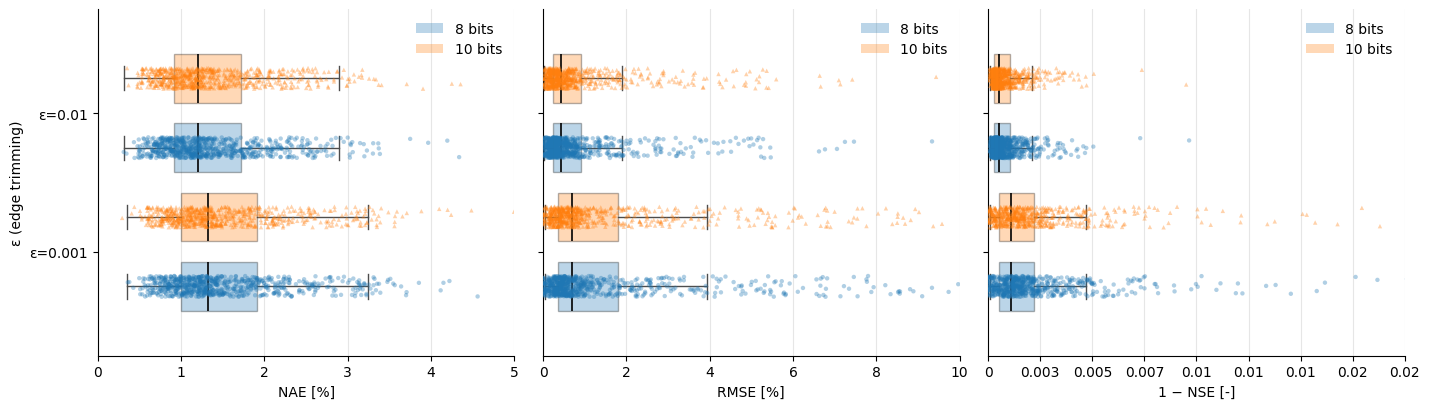

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch


def quant_boxplots_by_eps_and_m(all_results_dict, bit_test, eps_test, which_space='linear', which_bound=None):
    """
    Horizontal boxplots of score distributions grouped by ε,
    with side-by-side boxes for each m (bits) and jittered points.
    One panel per metric. NAE only for linear space.
    """
    assert which_space in ('linear', 'log')
    metrics = ['NAE', 'RMSE', 'EFF'] if which_space == 'linear' else ['RMSE', 'EFF']

    m_list = sorted(bit_test)
    m_colors = {m: c for m, c in zip(m_list, ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd'])}
    m_markers = {m: mk for m, mk in zip(m_list, ['o', '^', 's', 'D'])}

    n = len(metrics)
    fig, axs = plt.subplots(1, n, figsize=(4.8*n, 4.2), squeeze=False)
    axs = axs.ravel()

    eps_vals = sorted(eps_test)
    y_base = np.arange(1, len(eps_vals) + 1)
    dy = 0.25 if len(m_list) > 1 else 0.0
    offsets = np.linspace(-dy, dy, len(m_list)) if len(m_list) > 1 else [0.0]

    rng = np.random.default_rng(0)

    for i, (ax, metric) in enumerate(zip(axs, metrics)):
        col = f'{which_space}_{metric}_97.5ci' if which_bound == '97.5ci' else f'{which_space}_{metric}_mean'
        if metric == 'RMSE':
            col = f'linear_RMSE_97.5ci' if which_bound == '97.5ci' else f'linear_RMSE_mean'

        # collect data
        series = {(eps, m): None for eps in eps_vals for m in m_list}
        for eps in eps_vals:
            for m in m_list:
                df = all_results_dict[m][eps]
                # print(df.head())
                if col in df:
                    v = np.asarray(df[col].values, float)
                    v = v[np.isfinite(v)]
                    series[(eps, m)] = v if v.size else None

        # plot per (eps, m)
        for m, off in zip(m_list, offsets):
            data = [series[(eps, m)] for eps in eps_vals]
            pos = y_base + off
            clean_data, clean_pos = [], []
            for d, p in zip(data, pos):
                if d is not None and d.size:
                    clean_data.append(d)
                    clean_pos.append(p)
            if not clean_data:
                continue

            bp = ax.boxplot(
                clean_data, positions=clean_pos, vert=False, patch_artist=True,
                widths=0.35, showfliers=False,
                boxprops=dict(linewidth=1, facecolor=m_colors[m], alpha=0.3),
                medianprops=dict(color="k", linewidth=1.2),
                whiskerprops=dict(color="0.3", linewidth=1),
                capprops=dict(color="0.3", linewidth=1)
            )

            # jittered points (horizontal spread)
            for p, vals in zip(clean_pos, clean_data):
                yj = p + (rng.random(vals.size) - 0.5) * 0.15
                xj = vals + (rng.random(vals.size) - 0.5) * 0.02 * np.ptp(vals)
                ax.scatter(xj, yj, s=10, alpha=0.35, color=m_colors[m],
                           edgecolors="none", marker=m_markers[m], zorder=3)

        ax.set_yticks(y_base)
        ax.set_yticklabels([f'ε={e:g}' for e in eps_vals])
        ax.grid(axis='x', color='0.9', lw=0.8)
        if i == 0:
            ax.set_ylabel('ε (edge trimming)')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])

        # axis labels
        if metric == 'NAE':
            ax.set_xlabel('NAE [%]')
            ub = 10 if which_bound == '97.5ci' else 5
            ax.set_xlim(0, ub)
        elif metric == 'RMSE':
            ub = 20 if which_bound == '97.5ci' else 10
            if which_bound == '97.5ci':
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax.set_xlim(0, ub)
            ax.set_xlabel('RMSE [%]')
        else:
            ax.set_xlabel('1 − NSE [-]')
            ub = 0.04 if which_bound == '97.5ci' else 0.02
            ax.set_xlim(left=0.0, right=ub)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0g'))

        title = metric if metric != 'EFF' else '1 − NSE'
        # ax.set_title(title, fontsize=12)
        # remove border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        handles = [Patch(facecolor=m_colors[m], alpha=0.3, label=f'{m} bits') for m in m_list]
        ax.legend(handles=handles, loc='upper right', frameon=False, )

    
    
    plt.tight_layout()
    return fig

which_bound = 'mean'
# which_bound = '97.5ci'
fig = quant_boxplots_by_eps_and_m(all_results_dict, bit_test, eps_test, which_space='linear', which_bound=which_bound)
# save the figure to disk
fname = f'quantization_sensitivity_boxplots_linear_{which_bound}'
fig.savefig(os.path.join('images', f'{fname}.png'), dpi=150)

In [32]:

def quant_scatter_agreement_fixed(all_results_dict,
                                  which_space='linear',     # 'linear' or 'log'
                                  center='median',          # 'median' or 'mean'
                                  x_col=None,               # optional single-sample column
                                  figsize_per_panel=(4.8, 4.0),
                                  alpha=0.75):
    """
    One subplot per metric. x = single-sample estimate (if given) else center,
    y = bootstrap center, vertical whiskers = 95% CI. Uses only M=10 and eps=0.001.
    """
    # fixed selection
    m, eps = 10, 0.001
    df = all_results_dict[m][eps]

    # metrics per space
    metrics = ['NAE', 'RMSE', 'EFF'] if which_space == 'linear' else ['RMSE', 'EFF']
    labels = {'NAE':'NAE [%]', 'RMSE':'RMSE [%]', 'EFF':'1 − NSE [-]'}

    fig, axs = plt.subplots(1, len(metrics),
                            figsize=(figsize_per_panel[0]*len(metrics), figsize_per_panel[1]),
                            squeeze=False)
    axs = axs.ravel()

    # collect global limits (so panels are comparable)
    gx_min = np.inf; gx_max = -np.inf
    gy_min = np.inf; gy_max = -np.inf
    cache = {}
    xranges = {}
    for metric in metrics:
        base = f"{which_space}_{metric}"
        y_col  = f"{base}_{center}" if f"{base}_{center}" in df.columns else f"{base}_mean"
        lo_col = f"{base}_2.5ci"
        hi_col = f"{base}_97.5ci"

        if y_col not in df.columns:
            cache[metric] = None
            continue

        y  = df[y_col].to_numpy(float)
        x  = (df[x_col].to_numpy(float) if x_col and x_col in df.columns else y.copy())
        if lo_col in df.columns and hi_col in df.columns:
            ylo = df[lo_col].to_numpy(float)
            yhi = df[hi_col].to_numpy(float)
        elif hi_col in df.columns:
            yhi = df[hi_col].to_numpy(float)
            ylo = 2*y - yhi  # symmetric fallback
        else:
            ylo = y.copy(); yhi = y.copy()

        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(ylo) & np.isfinite(yhi)
        x, y, ylo, yhi = x[mask], y[mask], ylo[mask], yhi[mask]

        cache[metric] = (x, y, ylo, yhi, min(x), max(x))

    # plot
    for ax, metric in zip(axs, metrics):
        entry = cache.get(metric)
        if not entry: continue
        x, y, ylo, yhi, gx_min, gx_max = entry
        yerr = np.vstack([y - ylo, yhi - y])

        ax.errorbar(x, y, yerr=yerr, fmt='o', ms=3, alpha=alpha,
                    ecolor='0.25', elinewidth=0.8, color='0.15', lw=0)

        # identity line
        lo = min(gx_min, gy_min); hi = max(gx_max, gy_max)
        ax.plot([lo, hi], [lo, hi], ls='--', lw=1, color='0.4', label='1:1 line')

        ax.set_xlabel(f"Single-sample (baseline) {labels[metric]}")
        ax.set_ylabel(f"Bootstrap {labels[metric]} (95% CI)")
        ax.set_xlim(0, gx_max)
        print(metric)
        if metric == 'EFF':
            ax.set_xlim(0, 0.04)
            ax.set_ylim(-0.01, 0.3)

        xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ax.fill_between(xs, 0.5*xs, 2.0*xs,
                        color='grey', alpha=0.4, label='±100% region', zorder=0)

        # clean look
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.grid(True, color='0.85', lw=0.8, zorder = 1)
        ax.legend(loc='upper left', frameon=False)

    fig.tight_layout()
    return fig, axs

NAE
RMSE
EFF


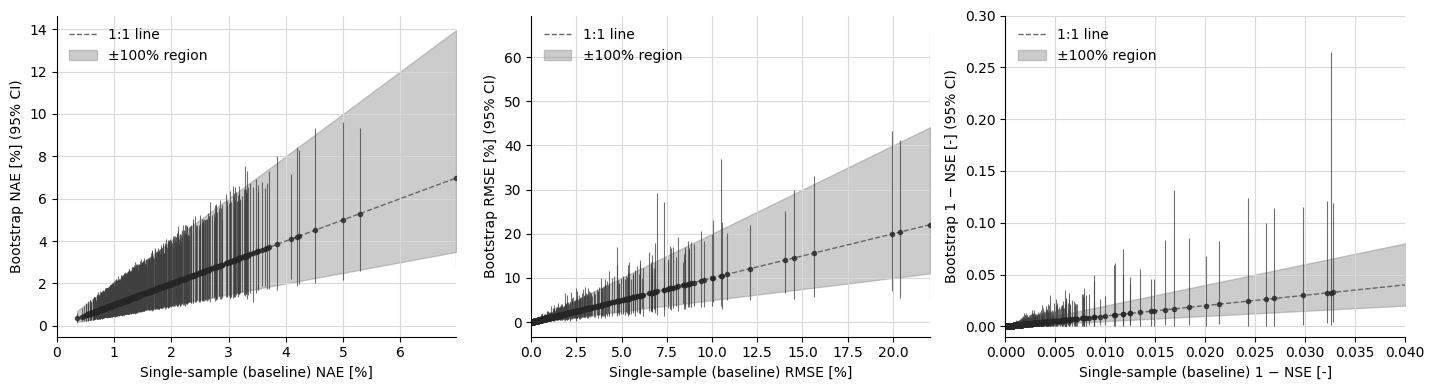

In [33]:
fig, axs = quant_scatter_agreement_fixed(all_results_dict,
                                         which_space='linear',
                                         center='median',
                                         x_col=None)
# save the figure to disk
fig.savefig(os.path.join('images', 'quantization_sensitivity_baseline_vs_bootstrap.png'), dpi=150)

### Examine model sensitivity to sampling variability

1.  **Log-normal**: the log normal model does not generate daily time series.  We have 20 iterations of the xgboost model that yield 20 sets of predicted statistics, and thus 20 sets of log-normal parameters.  We can compute the FDC for each set of parameters and evaluate the variability of scores $S$ over each metric compared to the reference FDC.  but the reference FDC is also estimated from a finite sample, so we should also consider the variability of the reference FDC. A double-bootstrap is a bit much...

In [34]:
# load the predicted mean uar and std for all 20 trials
predicted_param_trials_folder = Path('data/results/parameter_prediction_results')
predicted_mean_trials_fname = 'log_uar_mean_summary_group_3.csv'
predicted_std_trials_fname = 'log_uar_std_summary_group_3.csv'
predicted_lin_mean_trials_fname = 'uar_mean_summary_group_3.csv'
predicted_lin_std_trials_fname = 'uar_std_summary_group_3.csv'

predicted_mean_df = pd.read_csv(predicted_param_trials_folder / predicted_mean_trials_fname, dtype={'official_id': str})
predicted_std_df  = pd.read_csv(predicted_param_trials_folder / predicted_std_trials_fname, dtype={'official_id': str})
predicted_lin_mean_df = pd.read_csv(predicted_param_trials_folder / predicted_lin_mean_trials_fname, dtype={'official_id': str})
predicted_lin_std_df  = pd.read_csv(predicted_param_trials_folder / predicted_lin_std_trials_fname, dtype={'official_id': str})

pred_mean_dict = predicted_mean_df.groupby("official_id")["predicted"].apply(list).to_dict()
pred_std_dict  = predicted_std_df.groupby("official_id")["predicted"].apply(list).to_dict()
actual_mean_dict = predicted_mean_df.groupby('official_id')['actual'].apply(list).to_dict()
actual_std_dict  = predicted_std_df.groupby('official_id')['actual'].apply(list).to_dict()
predicted_lin_mean_dict = predicted_lin_mean_df.groupby("official_id")["predicted"].apply(list).to_dict()
predicted_lin_std_dict  = predicted_lin_std_df.groupby("official_id")["predicted"].apply(list).to_dict()
actual_lin_mean_dict = predicted_lin_mean_df.groupby('official_id')['actual'].apply(list).to_dict()
actual_lin_std_dict  = predicted_lin_std_df.groupby('official_id')['actual'].apply(list).to_dict()


In [35]:
from utils.parametric_estimator import ParametricFDCEstimator
from utils.evaluation_metrics import EvaluationMetrics
import multiprocessing as mp

B = 200

output_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_sensitivity_test_parametric.csv')
if os.path.exists(output_fpath):
    output_df = pd.read_csv(output_fpath, dtype={'official_id': str}, index_col=0)
    print(output_df.head())
else:
    all_trials = []
    for stn in daymet_concurrent_stations:
        
        # get the target data
        test_data = StationData(context, stn)
        test_data.eval_metrics = EvaluationMetrics(data=test_data)
        S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
        target_da= stn_da_dict[stn]
        
        # manually set the baseline observed pmf to the observed instead of the default kde fit
        baseline_pmf = test_data.baseline_obs_pmf

        # get the parametric estimates
        lognorm_estimator = ParametricFDCEstimator(context, test_data)
        lognorm_estimator.include_random_test = False

        predicted_mu_vals = pred_mean_dict[stn]
        predicted_sigma_vals = pred_std_dict[stn]
        actual_mu = actual_mean_dict[stn]
        actual_sigma = actual_std_dict[stn]
        predicted_lin_mu_vals = predicted_lin_mean_dict[stn]
        predicted_lin_sigma_vals = predicted_lin_std_dict[stn]
        actual_lin_mu = actual_lin_mean_dict[stn]
        actual_lin_sigma = actual_lin_std_dict[stn]

        for mu, sigma, act_mu, act_sigma, lin_mu, lin_sigma, lin_act_mu, lin_act_sigma in zip(
            predicted_mu_vals, predicted_sigma_vals, actual_mu, actual_sigma,
            predicted_lin_mu_vals, predicted_lin_sigma_vals, actual_lin_mu, actual_lin_sigma
        ):
            lognorm_estimator.predicted_param_dict = {
            stn: {
                'log_uar_mean_predicted': mu,
                'log_uar_std_predicted': sigma,
                'log_uar_mean_actual': act_mu,
                'log_uar_std_actual': act_sigma,
                'uar_mean_predicted': lin_mu,
                'uar_std_predicted': lin_sigma,
                'uar_mean_actual': lin_act_mu,
                'uar_std_actual': lin_act_sigma,
                'mu_random': np.random.choice(actual_mu),
                'sigma_random': np.random.choice(actual_sigma),
                }
            }
            result = lognorm_estimator.run_estimators()
            for k, r in result.items():
                if k == 'MLE':
                    continue
                test_result = r['eval']
                result_df = pd.DataFrame(test_result, index=[k])
                result_df['official_id'] = stn
                all_trials.append(result_df)
                if len(all_trials) % (20 * 50) == 0:
                    print(f'   Processed {len(all_trials)/20:.0f}/{len(daymet_concurrent_stations)} trials')
    
    output_df = pd.concat(all_trials)
    output_df.to_csv(output_fpath, index=True)

        

              pct_vol_bias  mean_error  mean_abs_rel_error      rmse  \
PredictedLog     -0.018214   -2.039885            0.066997  0.092378   
PredictedMOM      0.056055    6.277997            0.146716  0.192451   
PredictedLog      0.109970   12.316333            0.168262  0.211160   
PredictedMOM      0.073322    8.211905            0.104039  0.123760   
PredictedLog      0.082876    9.281938            0.108983  0.126934   

                   nse       kge        ve     pb_50       kld      emd  \
PredictedLog  0.992206  0.960905  0.959645  2.259851  0.081081   7.3514   
PredictedMOM  0.966171  0.840621  0.904895  5.325780  0.117695  15.3954   
PredictedLog  0.959274  0.934096  0.890030  6.158166  0.090081  15.2939   
PredictedMOM  0.986010  0.905840  0.912936  4.875486  0.090077  13.7501   
PredictedLog  0.985283  0.902881  0.903861  5.383685  0.090830  14.8661   

             official_id  
PredictedLog    12137290  
PredictedMOM    12137290  
PredictedLog    12137290  
Predicte

In [36]:

plots = []
metrics = ['pct_vol_bias', 'rmse', 'nse', 'kld']
metrics = ['ve', 'rmse', 'nse', 'kld']
param_data = {}
for l in sorted(list(set(output_df.index.values))):
    print(l)
    model_output_df = output_df[output_df.index == l].copy()
    all_station_results = model_output_df[metrics + ['official_id']].groupby('official_id').agg(lambda x: np.percentile(x, (2.5, 50, 95)).tolist())
    param_data[l] = {}
    for m in metrics:        
        by_station = all_station_results.copy().sort_values(by=m, key=lambda x: [e[1] for e in x])
        lb = [e[0] for e in by_station[m].values]
        median = [e[1] for e in by_station[m].values]
        ub = [e[2] for e in by_station[m].values]

        m_df = pd.DataFrame({'lb': sorted(lb), 'median': sorted(median), 'ub': sorted(ub)})
        max_pt = 1
        N = len(m_df)
        
        label = m.upper()
        xmin, xmax = 0, 4
        if m == 've':
            label = 'NAE [%]'
            m_df[['lb', 'median', 'ub']] = 100 * (1 - m_df[['lb', 'median', 'ub']]) # express as %, 0 is perfect
            m_df.sort_values(by='median', inplace=True)
            xmin, xmax = 0, 150
        elif m == 'pct_vol_bias':
            label = 'PB [%]'
            m_df = 100 * m_df       # express as %, 0 is perfect
            xmin, xmax = -200, 50
        elif m == 'nse':
            label = '1 - NSE [-]'
            m_df[['lb', 'median', 'ub']] = 1 - m_df[['lb', 'median', 'ub']]         # 1-NSE, 0 is perfect
            # sort by median again
            m_df.sort_values(by='median', inplace=True)
            m_df = m_df         # 1-NSE, 0 is perfect
            xmin, xmax = 0, 2
        elif m == 'rmse':
            label = 'RMSE [%]'
            m_df = 100*(np.exp(m_df) - 1)       # express as %, 0 is perfect
            xmin, xmax = 0, 400
        elif m == 'kld':
            label = 'KLD [bits/sample]'
            m_df = m_df         # 0 is perfect
            xmin, xmax = 0, 3

        p = figure(title=f'{l}', width=600, height=400, toolbar_location=None,
                   x_range=(xmin, xmax))

        m_df['y'] = (np.arange(N) + 0.5) / N
        source = ColumnDataSource(m_df)
        param_data[l][m] = source
                
        # CI bars aligned to each median’s ECDF position
        llabel = '95% CI' if len(plots) == 0 else ''
        if len(plots) == 3:
            p.harea(x1='lb', y='y', x2='ub', source=source, legend_label=llabel,
                    color='dodgerblue', alpha=0.5)
            p.step('median', 'y', source=source, mode='after', line_width=2, color='black', legend_label='Median')
            p.legend.location = 'bottom_right'
        else:
            p.harea(x1='lb', y='y', x2='ub', source=source,                    
                    color='dodgerblue', alpha=0.5)
            p.step('median', 'y', source=source, mode='after', line_width=2, color='black')

        p = dpf.format_fig_fonts(p, font_size=14)
        p.xaxis.axis_label = label
        p.yaxis.axis_label = 'Cumulative Density'
        plots.append(p)
        
lt = gridplot(plots, ncols=4, width=350, height=300, toolbar_location=None)
fname = f'parametric_estimator_uncertainty'
dpf.save_fig(lt, fname)
show(lt)

PredictedLog
PredictedMOM
Figure saved to images/parametric_estimator_uncertainty.png


Now import the LSTM simulation ensemble and test results on individual simulated outputs.  These are also somewhat limited since there are only 20 independent simulations.

We already use the ensemble mixture distribution of all simulations which should address some of the variability, however this is based on a limited sample.   So we test the variability of scores by bootstrap resampling the 20 simulations with replacement to generate a larger sample of FDC estimates with which to generate the the ensemble mixture.  This approach should express sensitivity of the ensemble mixture to sampling variability given a small sample of simulations.

In [38]:
from utils.LSTM_estimator import LSTMFDCEstimator
from utils.evaluation_metrics import EvaluationMetrics
import multiprocessing as mp

B = 200

output_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_sensitivity_test_LSTM.csv')
if os.path.exists(output_fpath):
    lstm_test_df = pd.read_csv(output_fpath, dtype={'official_id': str})
else:
    all_trials = []
    for stn in daymet_concurrent_stations:
        
        # get the target data
        test_data = StationData(context, stn)
        test_data.eval_metrics = EvaluationMetrics(data=test_data)
        S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
        target_da= stn_da_dict[stn]
        # manually set the baseline pmf to the observed empirical, not the kde fit
        baseline_pmf = test_data.baseline_obs_pmf

        # get the parametric estimates
        lstm_estimator = LSTMFDCEstimator(context, test_data)
        
        sim_df = lstm_estimator.df.copy()

        sim_cols = [c for c in sim_df.columns if c.startswith('streamflow_sim_')]
        # set up bootstrap resampling of the sim_cols to test sampling variability of the LSTM ensemble
        rng = np.random.default_rng(42)
        sim_col_sets = [rng.choice(sim_cols, size=len(sim_cols), replace=True) for _ in range(B)]
        for i, ss in enumerate(sim_col_sets):
            pmf = lstm_estimator.compute_ensemble_pmf_by_bincount(sim_df, ss, test_data.log_edges)
            _, prior_adjusted_pmf = test_data._compute_adjusted_distribution_with_mixed_uniform(pmf)

            result = test_data.eval_metrics._evaluate_fdc_metrics_from_pmf(prior_adjusted_pmf, test_data.baseline_obs_pmf)
            result['official_id'] = stn
            all_trials.append(result)
            
        if len(all_trials) % (100 * 20 * 50) == 0:
            print(f'   Processed {len(all_trials)/20:.0f}/{len(daymet_concurrent_stations)} trials')

    lstm_test_df = pd.DataFrame(all_trials)
    lstm_test_df.to_csv(output_fpath, index=True)

Now test on one kNN model.  We can pick a single model variant.  Perhaps based on a bounding condition, like which model should be most sensitive -- 1 nearest neighbour will be most sensitive. Pick nearest neighbour in attribute space.  



In [39]:
from utils.knn_estimator import kNNEstimator
from utils.evaluation_metrics import EvaluationMetrics
import multiprocessing as mp

B = 200
delta_values = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

output_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_sensitivity_test_knn.csv')

if os.path.exists(output_fpath):
    knn_result_df = pd.read_csv(output_fpath, dtype={'official_id': str})
else:
    all_trials = []
    for nn, stn in enumerate(daymet_concurrent_stations):
        print(f'    Processing station {nn+1}/{len(daymet_concurrent_stations)}: {stn}')
        
        # get the target data
        test_data = StationData(context, stn)
        test_data.eval_metrics = EvaluationMetrics(data=test_data)
        test_data.k_nearest = 1
        S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
        target_da= stn_da_dict[stn]

        baseline_pmf = test_data.baseline_obs_pmf

        # get the parametric estimates
        knn_estimator = kNNEstimator(context, test_data)
        knn_estimator.baseline_pmf_type = 'obs' # use the observed or kde approximated pmf as the baseline
        knn_estimator.k_nearest = 4
        knn_estimator._initialize_nearest_neighbour_data()
        knn_estimator.weight_schemes = [2] # only look at inverse square distance weighting

        nbr_df = knn_estimator.nbr_dfs['attribute_dist']['nbr_df'].copy()
        nbr_data = knn_estimator.nbr_dfs['attribute_dist']['nbr_data'].copy()
        # 2 is for weighting by inverse square distance
        # set a range of deltas to test the sensitivity to the uniform mixture
        
        for d in delta_values:
            test_data.delta = d
            knn_estimator._compute_ensemble_distributions(2, nbr_df, nbr_data, 'attribute_dist')
            sim_data = knn_estimator.knn_simulation_data
            for c in sim_data.keys():
                result = sim_data[c]['eval']
                result['official_id'] = stn
                result['delta'] = d
                result['k'] = sim_data[c]['k']
                result['weight_scheme'] = 2
                all_trials.append(result)
    knn_result_df = pd.DataFrame(all_trials)
    knn_result_df.to_csv(output_fpath, index=False)


In [40]:
range_dict = {
    'pct_vol_bias': (-200, 50),
    've': (0, 150),
    'rmse': (0, 400),
    'nse': (0, 2),
    'kld': (0, 3)
}
label_dict = {
    'pct_vol_bias': 'PB [%]',
    've': 'NAE [%]',
    'rmse': 'RMSE [%]',
    'nse': '1 - NSE [-]',
    'kld': 'KLD [bits/sample]'
}
from bokeh.palettes import Category10, Sunset10, Bokeh4, Colorblind5
palette = Sunset10
palette = Colorblind5


In [45]:
knn_data = {}
plots = []
k_set = sorted(list(set(knn_result_df['k'].values)))
k_set = [1, 2, 4]
for k in k_set:

    model_output_df = knn_result_df[knn_result_df['k'] == k].copy()
    
    knn_data[str(k)] = {}
    for m in metrics:
        
        xmin, xmax = range_dict[m]   
        p = figure(title=f'{k}NN', width=600, height=400, x_range=(xmin, xmax))
        m_df = pd.DataFrame()     
        nn = 0
        for i, d in enumerate(sorted(list(set(model_output_df['delta'].values)))):
            nn += 1 if nn == 2 else 0

            if d <= 5e-4:
                continue

            by_station = model_output_df[model_output_df['delta'] == d].copy()
                        
            # max_pt = 1
            # N = len(m_df)
            values = by_station[m].values
            
            label = m.upper()
            if m == 've':
                label = 'NAE [%]'
                values = 100 * (1 - values) # express as %, 0 is perfect                                
            elif m == 'pct_vol_bias':
                label = 'PB [%]'
                values = 100 * values       # express as %, 0 is perfect
            elif m == 'nse':
                label = ' 1 - NSE [-]'
                values = 1 - values         # 1-NSE, 0 is perfect
                # sort by median again
            elif m == 'rmse':
                label = 'RMSE [%]'
                values = 100*(np.exp(values) - 1)       # express as %, 0 is perfect
            elif m == 'kld':
                label = 'KLD [bits/sample]'            

            m_df[str(d)] = sorted(values)
            m_df['y'] = (np.arange(len(m_df)) + 0.5) / len(m_df)
            knn_data[str(k)][str(d)] = ColumnDataSource(m_df)
            # CI bars aligned to each median’s ECDF position
            
            if len(plots) == 3:
                p.legend.location = 'bottom_right'
                p.legend.click_policy="hide"
                p.legend.background_fill_alpha = 0.5
                p.line(str(d), 'y', source=knn_data[str(k)][str(d)], line_width=2, color=palette[nn], legend_label=f'δ={d}')
            else:
                p.line(str(d), 'y', source=knn_data[str(k)][str(d)], line_width=2, color=palette[nn])
            nn += 1

        p = dpf.format_fig_fonts(p, font_size=13)
        if len(plots) >= 8:
            p.xaxis.axis_label = label
        if len(plots) % 4 == 0:
            p.yaxis.axis_label = 'Cumulative Density'
        plots.append(p)
        
lt = gridplot(plots, ncols=4, width=275, height=275, toolbar_location=None)
fname = f'knn_delta_mixture_uncertainty'
dpf.save_fig(lt, fname)
show(lt)

/tmp/ipykernel_1377912/3028616286.py:51: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.location = 'bottom_right'
/tmp/ipykernel_1377912/3028616286.py:52: UserWarning: 
You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.click_policy="hide"
/tmp/ipykernel_1377912/3028616286.py:53: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.background_fill_alpha 

Figure saved to images/knn_delta_mixture_uncertainty.png


In [46]:
plots = []
metrics = ['ve', 'rmse', 'nse', 'kld']

# model_output_df = lstm_df[lstm_df.index == l].copy()
all_station_results = lstm_test_df[metrics + ['official_id']].groupby('official_id').agg(lambda x: np.percentile(x, (2.5, 50, 95)).tolist())

for m in metrics:
    by_station = all_station_results.copy().sort_values(by=m, key=lambda x: [e[1] for e in x])
    lb = [round(e[0], 4) for e in by_station[m].values]
    median = [round(e[1], 4) for e in by_station[m].values]
    ub = [round(e[2], 4) for e in by_station[m].values]
    mean = [round(np.mean(e), 4) for e in by_station[m].values]
    # compute bootstrap resampled mean and 95% CI of the mean
    # using 1000 bootstrap samples
    resampled = np.array([np.random.choice(lstm_test_df[m].values.flatten(), size=len(by_station), replace=True) for _ in range(1000)])
    resampled_means = np.mean(resampled, axis=1)
    mean_ci = np.percentile(resampled_means, [2.5, 50, 97.5])
    print(f'{m}:  mean: {mean_ci[1]:.2f} 95% CI: {mean_ci[0]:.2f} - {mean_ci[2]:.2f}')

    lstm_df = pd.DataFrame({'lb': sorted(lb), 'median': sorted(median), 'ub': sorted(ub)})
    max_pt = 1
    N = len(lstm_df)
    
    label = m.upper()
    xmin, xmax = 0, 4
    if m == 've':
        label = 'NAE [%]'
        lstm_df[['lb', 'median', 'ub']] = 100 * (1 - lstm_df[['lb', 'median', 'ub']]) # express as %, 0 is perfect
        lstm_df.sort_values(by='median', inplace=True)
        xmin, xmax = 0, 150
    elif m == 'pct_vol_bias':
        label = 'PB [%]'
        lstm_df = 100 * lstm_df       # express as %, 0 is perfect
        xmin, xmax = -150, 75
    elif m == 'nse':
        label = '1 - NSE [-]'
        lstm_df[['lb', 'median', 'ub']] = 1 - lstm_df[['lb', 'median', 'ub']]         # 1-NSE, 0 is perfect
        # sort by median again
        lstm_df.sort_values(by='median', inplace=True)
        xmin, xmax = 0, 1.0
    elif m == 'rmse':
        label = 'RMSE [%]'
        lstm_df = 100*(np.exp(lstm_df) - 1)       # express as %, 0 is perfect
        xmin, xmax = 0, 150
    elif m == 'kld':
        label = 'KLD [bits/sample]'
        lstm_df = lstm_df         # 0 is perfect
        xmin, xmax = 0, 2

    p = figure(title=f'', width=600, height=400, toolbar_location=None,
                x_range=(xmin, xmax))

    lstm_df['y'] = (np.arange(N) + 0.5) / N
    source = ColumnDataSource(lstm_df)

    # get the parametric data source
    param_src = param_data['PredictedLog'][m]
            
    # CI bars aligned to each median’s ECDF position
    if len(plots) == 3:
        p.harea(x1='lb', y='y', x2='ub', source=source, legend_label='LSTM 95% CI',
                color='green', alpha=0.5)
        p.step('median', 'y', source=source, mode='after', line_width=2, color='darkgreen', legend_label='LSTM Median')
        p.legend.location = 'bottom_right'

        p.harea(x1='lb', y='y', x2='ub', source=param_src, legend_label='LogNorm 95% CI',
                color='dodgerblue', alpha=0.5)
        p.step('median', 'y', source=param_src, mode='after', line_width=2, color='navy', legend_label='LogNorm Median')
    else:
        p.harea(x1='lb', y='y', x2='ub', source=source,                    
                color='green', alpha=0.5)
        p.step('median', 'y', source=source, mode='after', line_width=2, color='darkgreen')
        p.harea(x1='lb', y='y', x2='ub', source=param_src, 
                color='dodgerblue', alpha=0.5)
        p.step('median', 'y', source=param_src, mode='after', line_width=2, color='navy')

    p = dpf.format_fig_fonts(p, font_size=14)
    p.xaxis.axis_label = label
    if len(plots) == 0:
        p.yaxis.axis_label = 'Cumulative Density'
    plots.append(p)
        
lt = gridplot(plots, ncols=4, width=350, height=300, toolbar_location=None)
fname = f'lstm_estimator_uncertainty'
dpf.save_fig(lt, fname)
show(lt)

ve:  mean: 0.74 95% CI: 0.72 - 0.76
rmse:  mean: 0.39 95% CI: 0.36 - 0.42
nse:  mean: 0.61 95% CI: 0.22 - 0.81
kld:  mean: 0.39 95% CI: 0.35 - 0.43
Figure saved to images/lstm_estimator_uncertainty.png


Test the sensitivity of FDCs predicted by kNN to sampling variability on the observations informing the reference distribution.

In [94]:

B = 100
delta = 0.01

output_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_sensitivity_test_knn_bootstrap_P.csv')

if os.path.exists(output_fpath):
    knn_result_df = pd.read_csv(output_fpath, dtype={'official_id': str})
else:
    all_trials = []
    for nn, stn in enumerate(daymet_concurrent_stations):
        print(f'    Processing station {nn+1}/{len(daymet_concurrent_stations)}: {stn}')
        
        # get the target data
        test_data = StationData(context, stn)
        test_data.eval_metrics = EvaluationMetrics(data=test_data)

        test_data.k_nearest = 1        
        target_da= stn_da_dict[stn]

        # baseline_pmf = test_data.baseline_obs_pmf

        # create a bootstrap resampling of the station data (use complete years)
        complete_years = complete_years_dict[stn]['complete_years']
        test_data.stn_df['year'] = test_data.stn_df.index.year
        test_data.stn_df = test_data.stn_df[test_data.stn_df['year'].isin(complete_years)].copy()
        # drop the year column
        test_data.stn_df.drop(columns=['year'], inplace=True)

        S = np.log(test_data.stn_df[f'{stn}_uar'].dropna().values)
        # initialize a random state
        rng = np.random.default_rng(42)
        # vectorized bootstrap resampling with replacement
        idx = np.random.choice(S.size, size=(S.size, B), replace=True)    
        S_b  = S[idx] # (n, B) bootstrap samples (column vectors of resampled data)

        bootstrap_histograms = np.apply_along_axis(lambda x: np.histogram(x, bins=test_data.log_edges, density=True)[0], arr=S_b, axis=0)

        # convert pdfs to pmfs
        bootstrap_histograms *= test_data.log_w[:, None]  # (M, B) multiply by the bin width

        # assert all PMFs sum to 1 
        assert np.allclose(np.sum(bootstrap_histograms, axis=0), 1), f'   sums do not equal 1:{np.sum(bootstrap_histograms, axis=0)}'

        # get the parametric estimates
        knn_estimator = kNNEstimator(context, test_data)
        knn_estimator.baseline_pmf_type = 'obs' # use the observed or kde approximated pmf as the baseline
        knn_estimator.k_nearest = 4
        knn_estimator._initialize_nearest_neighbour_data()
        
        knn_estimator.weight_schemes = [2] # only look at inverse square distance weighting

        nbr_df = knn_estimator.nbr_dfs['attribute_dist']['nbr_df'].copy()
        nbr_data = knn_estimator.nbr_dfs['attribute_dist']['nbr_data'].copy()
        # 2 is for weighting by inverse square distance
        # set a range of deltas to test the sensitivity to the uniform mixture

        
        
        test_data.delta = delta
        bootstrap_sample_results = knn_estimator._compare_bootstrap_P_to_ensemble_distributions(2, nbr_df, nbr_data, bootstrap_histograms, 'attribute_dist')
        
        for c in bootstrap_sample_results.keys():
            result = {}
            result['k'] = c
            result['official_id'] = stn
            result['delta'] = float(d)
            result['weight_scheme'] = 2
            sample_results = bootstrap_sample_results[c]
            sample_result_df = pd.DataFrame(sample_results)
            for pct in (2.5, 50, 97.5):
                ps = np.percentile(sample_result_df.values, pct, axis=0)
                # update the result dict
                result.update({f"{col}_{pct}": round(float(val), 5) for col, val in zip(sample_result_df.columns, ps)})
            all_trials.append(result)

    knn_bootstrap_df = pd.DataFrame(all_trials)
    knn_bootstrap_df.to_csv(output_fpath, index=False)

    Processing station 1/715: 15085100
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 2/715: 12100490
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 3/715: 12044900
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 4/715: 08NH120
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 5/715: 07FA006
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 6/715: 12457000
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 7/715: 08NE008
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 8/715: 12178100
    ...initializing nearest neighbours with minimum concurrent record.
    Processing station 9/715: 07AA001
    ...initializing nearest neighbours with minimum concurrent record.
    Processing

In [115]:
plots = []

range_dict = {
    've': [0, 150],
    'pct_vol_bias': [-150, 75],
    'nse': [0, 1],
    'rmse': [0, 150],
    'kld': [0, 2],
}
for k in [1, 2, 4]:  
    for m in metrics:
    
        metric_cols = [c for c in knn_bootstrap_df.columns if c.startswith(m)]
        all_station_results = knn_bootstrap_df[knn_bootstrap_df['k'] == k][metric_cols + ['official_id']].copy()
         
        p = figure(title=f'{k}NN', width=600, height=400, toolbar_location=None, x_axis_type='log')
        
        # if m == 'nae':
        #     all_station_results = 1 - all_station_results

        lb = all_station_results[f'{m}_2.5'].values
        median = all_station_results[f'{m}_50'].values
        ub = all_station_results[f'{m}_97.5'].values

        knn_df = pd.DataFrame({'lb': sorted(lb), 'median': sorted(median), 'ub': sorted(ub)})
        max_pt = 1
        N = len(lstm_df)
        
        label = m.upper()
        xmin, xmax = 0, 4
        if m == 've':
            label = 'NAE [%]'
            knn_df[['lb', 'median', 'ub']] = 100 * (1 - knn_df[['lb', 'median', 'ub']]) # express as %, 0 is perfect
            knn_df.sort_values(by='median', inplace=True)
            xmin, xmax = 0, 150
        elif m == 'pct_vol_bias':
            label = 'PB [%]'
            knn_df = 100 * knn_df       # express as %, 0 is perfect
            xmin, xmax = -150, 75
        elif m == 'nse':
            label = '1 NSE [-]'
            knn_df[['lb', 'median', 'ub']] = 1 - knn_df[['lb', 'median', 'ub']]         # 1-NSE, 0 is perfect
            # sort by median again
            knn_df.sort_values(by='median', inplace=True)
            xmin, xmax = 0, 1.0
        elif m == 'rmse':
            label = 'RMSE [%]'
            knn_df = 100*(np.exp(knn_df) - 1)       # express as %, 0 is perfect
            xmin, xmax = 0, 150
        elif m == 'kld':
            label = 'KLD [bits/sample]'
            xmin, xmax = 0, 2

        N = len(knn_df)
        knn_df['y'] = (np.arange(N) + 0.5) / N
        source = ColumnDataSource(knn_df)

        # get the parametric data source
        param_src = param_data['PredictedLog'][m]
                
        # CI bars aligned to each median’s ECDF position
        if len(plots) == 3:
            p.harea(x1='lb', y='y', x2='ub', source=param_src, legend_label='LogNorm 95% CI',
                    color='dodgerblue', alpha=0.5)
            p.step('median', 'y', source=param_src, mode='after', line_width=2, color='navy', legend_label='LogNorm Median')
            p.harea(x1='lb', y='y', x2='ub', source=source, legend_label='kNN 95% CI',
                    color='orange', alpha=0.5)
            p.step('median', 'y', source=source, mode='after', line_width=2, color='darkorange', legend_label='kNN Median')
            p.legend.location = 'bottom_right'
            p.legend.background_fill_alpha = 0.5
        else:
            p.harea(x1='lb', y='y', x2='ub', source=param_src, 
                    color='dodgerblue', alpha=0.5)
            p.step('median', 'y', source=param_src, mode='after', line_width=2, color='navy')
            p.harea(x1='lb', y='y', x2='ub', source=source,                    
                    color='orange', alpha=0.5)
            p.step('median', 'y', source=source, mode='after', line_width=2, color='darkorange')


        p = dpf.format_fig_fonts(p, font_size=14)
        if len(plots) >= 8:
            p.xaxis.axis_label = label
        if len(plots) % 4 == 0:
            p.yaxis.axis_label = 'Cumulative Density'
        plots.append(p)

lt = gridplot(plots, ncols=4, width=350, height=300, toolbar_location=None)
fname = f'knn_bootstrap_uncertainty'
dpf.save_fig(lt, fname)
show(lt)

Figure saved to images/knn_bootstrap_uncertainty.png
